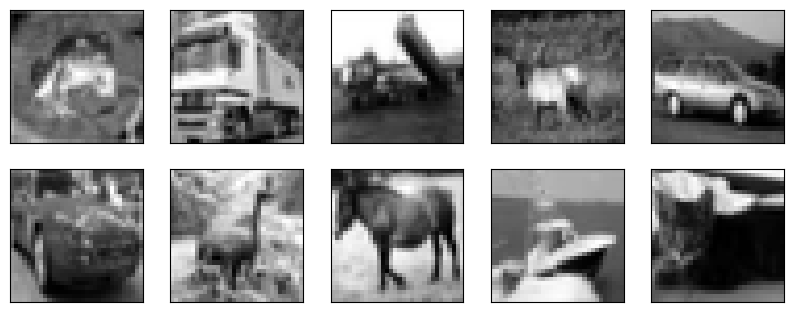

(50000, 32, 32, 1)
(10000, 32, 32, 1)


In [10]:
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from sklearn.metrics import accuracy_score
import numpy as np

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, accuracy_score

# Load CIFAR-10 dataset with original variable names
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train.astype('float32') / 255.0, X_test.astype('float32') / 255.0

# Convert images to grayscale
X_train_gray = tf.image.rgb_to_grayscale(X_train).numpy()
X_test_gray = tf.image.rgb_to_grayscale(X_test).numpy()

# Visualize a few grayscale images from the dataset
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(tf.squeeze(X_train_gray[i]), cmap='gray')  # Use tf.squeeze to remove the singleton dimension
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

print(X_train_gray.shape)
print(X_test_gray.shape)

Layer Name: encoder_conv1
Filters: 16, Kernel Size: (3, 3)
Layer Name: encoder_conv2
Filters: 8, Kernel Size: (3, 3)
Layer Name: encoder_conv3
Filters: 8, Kernel Size: (3, 3)
Layer Name: decoder_conv1
Filters: 8, Kernel Size: (3, 3)
Layer Name: decoder_conv2
Filters: 8, Kernel Size: (3, 3)
Layer Name: decoder_conv3
Filters: 16, Kernel Size: (3, 3)
Layer Name: output_layer
Filters: 1, Kernel Size: (3, 3)
Model: "autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 encoder_conv1 (Conv2D)      (None, 32, 32, 16)        160       
                                                                 
 encoder_pool1 (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                      

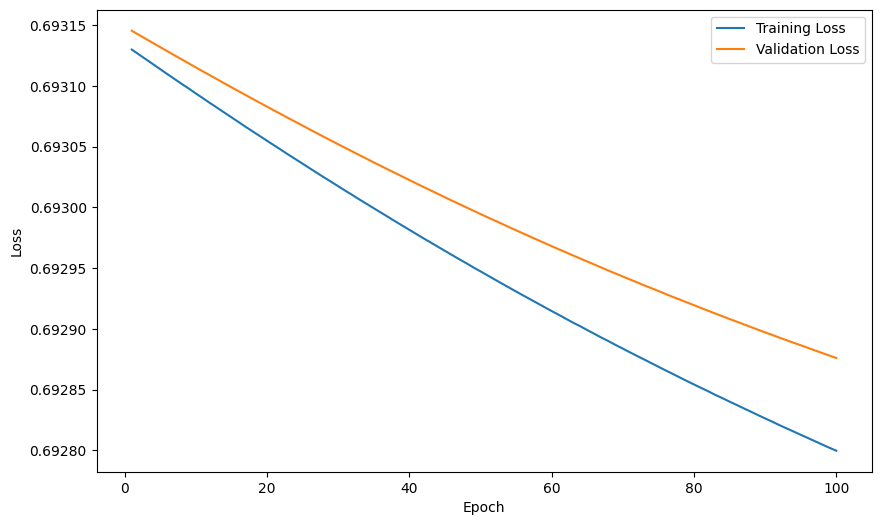

313/313 [==============================] - 3s 9ms/step


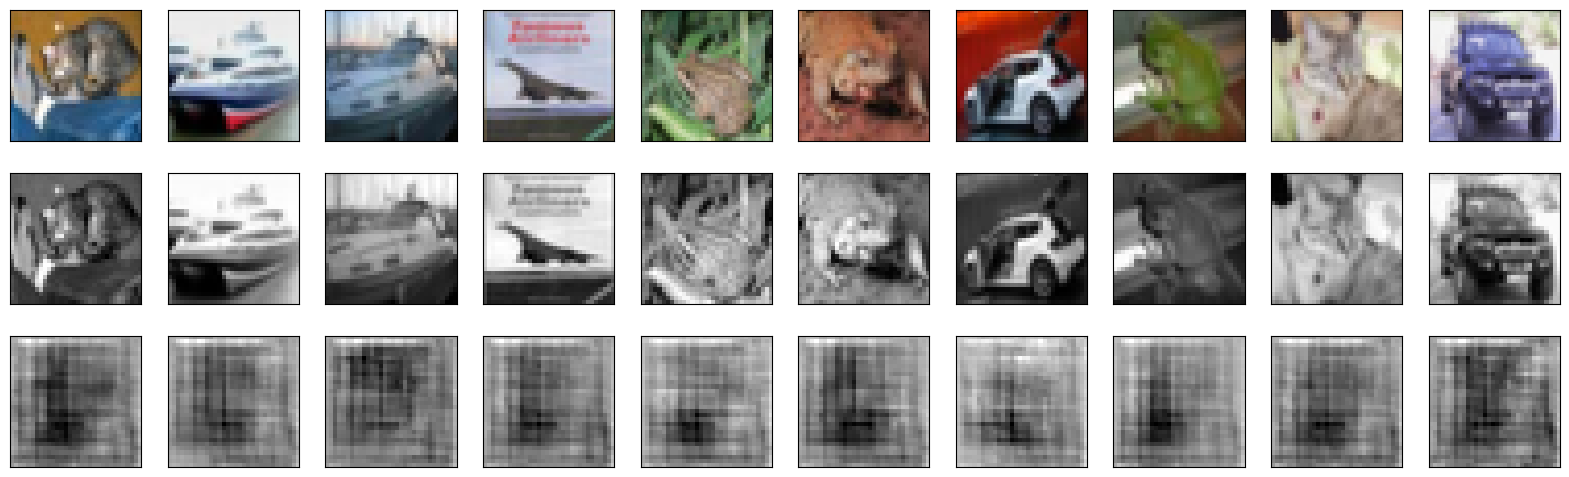

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Define the input layer
input_img = Input(shape=(32, 32, 1), name='input_layer')  # Assuming input shape is (32, 32, 1)

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='encoder_pool1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
x = MaxPooling2D((2, 2), padding='same', name='encoder_pool2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder_pool3')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv1')(encoded)
x = UpSampling2D((2, 2), name='decoder_upsample1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
x = UpSampling2D((2, 2), name='decoder_upsample2')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='decoder_conv3')(x)
x = UpSampling2D((2, 2), name='decoder_upsample3')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output_layer')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded, name='autoencoder_model')


# Print attributes of each layer
# Print only name, filters, and kernel size for Conv2D layers
for layer in autoencoder.layers:
    if isinstance(layer, Conv2D):
        layer_info = layer.get_config()
        print(f"Layer Name: {layer.name}")
        print(f"Filters: {layer_info['filters']}, Kernel Size: {layer_info['kernel_size']}")
        print("=====================================================")


autoencoder.compile(optimizer='sgd', loss='binary_crossentropy')
autoencoder.summary()
# Autoencoder model


# Measure training time
start_time = time.time()

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Train the autoencoder
for epoch in range(100):
    loss = autoencoder.train_on_batch(X_train_gray, X_train_gray)
    val_loss = autoencoder.test_on_batch(X_test_gray, X_test_gray)

    train_losses.append(loss)
    val_losses.append(val_loss)

    # Encode and decode some images for accuracy calculation
    decoded_images_train = autoencoder.predict(X_train_gray)
    decoded_images_test = autoencoder.predict(X_test_gray)

    # Pixel-wise accuracy
    pixel_accuracy_train = accuracy_score(X_train_gray.flatten().round(), decoded_images_train.flatten().round())
    pixel_accuracy_test = accuracy_score(X_test_gray.flatten().round(), decoded_images_test.flatten().round())

    # Mean Squared Error (MSE)
    mse_train = np.mean((X_train_gray - decoded_images_train) ** 2)
    mse_test = np.mean((X_test_gray - decoded_images_test) ** 2)

    # Peak Signal-to-Noise Ratio (PSNR)
    max_pixel_value = 1.0  # Assuming pixel values are normalized between 0 and 1
    psnr_train = 10 * np.log10((max_pixel_value ** 2) / mse_train)
    psnr_test = 10 * np.log10((max_pixel_value ** 2) / mse_test)
    print(f"Epoch {epoch + 1}/100 - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - "
            f"Train Pixel Accuracy: {pixel_accuracy_train * 100:.2f}% - "
            f"Test Pixel Accuracy: {pixel_accuracy_test * 100:.2f}% - "
            f"Train MSE: {mse_train:.4f} - Test MSE: {mse_test:.4f}")

# Calculate and print training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


# Plot Losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Encode and decode some images for visualization
decoded_images = autoencoder.predict(X_test_gray)

# Display original, grayscale, and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))

for i in range(n):
    # Display original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display grayscale image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(tf.squeeze(X_test_gray[i]), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(tf.squeeze(decoded_images[i]), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [14]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score
from skimage.metrics import peak_signal_noise_ratio

# Perform PCA on training set
pca_train = PCA(n_components=0.90, random_state=42)
X_train_pca = pca_train.fit_transform(X_train_standardized)

# Perform PCA on test set
X_test_flat = X_test_gray.reshape((len(X_test_gray), -1))
X_test_standardized = (X_test_flat - np.mean(X_test_flat, axis=0)) / np.std(X_test_flat, axis=0)
X_test_pca = pca_train.transform(X_test_standardized)  # Reusing the same pca_train object

# Number of components to keep
n_components_train = X_train_pca.shape[1]
n_components_test = X_test_pca.shape[1]

# Reconstruct images using inverse_transform for training set
X_train_reconstructed = pca_train.inverse_transform(X_train_pca)

# Reconstruct images using inverse_transform for test set
X_test_reconstructed = pca_train.inverse_transform(X_test_pca)  # Reusing the same pca_train object

# Reshape the reconstructed data to match the original shape
X_train_reconstructed = X_train_reconstructed.reshape(X_train_gray.shape)
X_test_reconstructed = X_test_reconstructed.reshape(X_test_gray.shape)

# Calculate and print metrics for training set
mse_train = mean_squared_error(X_train_gray.flatten(), X_train_reconstructed.flatten())
pixel_accuracy_train = accuracy_score(X_train_gray.flatten().round(), X_train_reconstructed.flatten().round())
psnr_train = peak_signal_noise_ratio(X_train_gray.flatten(), X_train_reconstructed.flatten())

# Calculate and print metrics for test set
mse_test = mean_squared_error(X_test_gray.flatten(), X_test_reconstructed.flatten())
pixel_accuracy_test = accuracy_score(X_test_gray.flatten().round(), X_test_reconstructed.flatten().round())
psnr_test = peak_signal_noise_ratio(X_test_gray.flatten(), X_test_reconstructed.flatten())

print(f"MSE on training set: {mse_train:.4f}")
print(f"Pixel Accuracy on training set: {pixel_accuracy_train * 100:.2f}%")
print(f"PSNR on training set: {psnr_train:.4f}")

print(f"MSE on test set: {mse_test:.4f}")
print(f"Pixel Accuracy on test set: {pixel_accuracy_test * 100:.2f}%")
print(f"PSNR on test set: {psnr_test:.4f}")


MSE on training set: 0.7616
Pixel Accuracy on training set: 44.53%
PSNR on training set: 1.1829
MSE on test set: 0.7650
Pixel Accuracy on test set: 44.24%
PSNR on test set: 1.1636


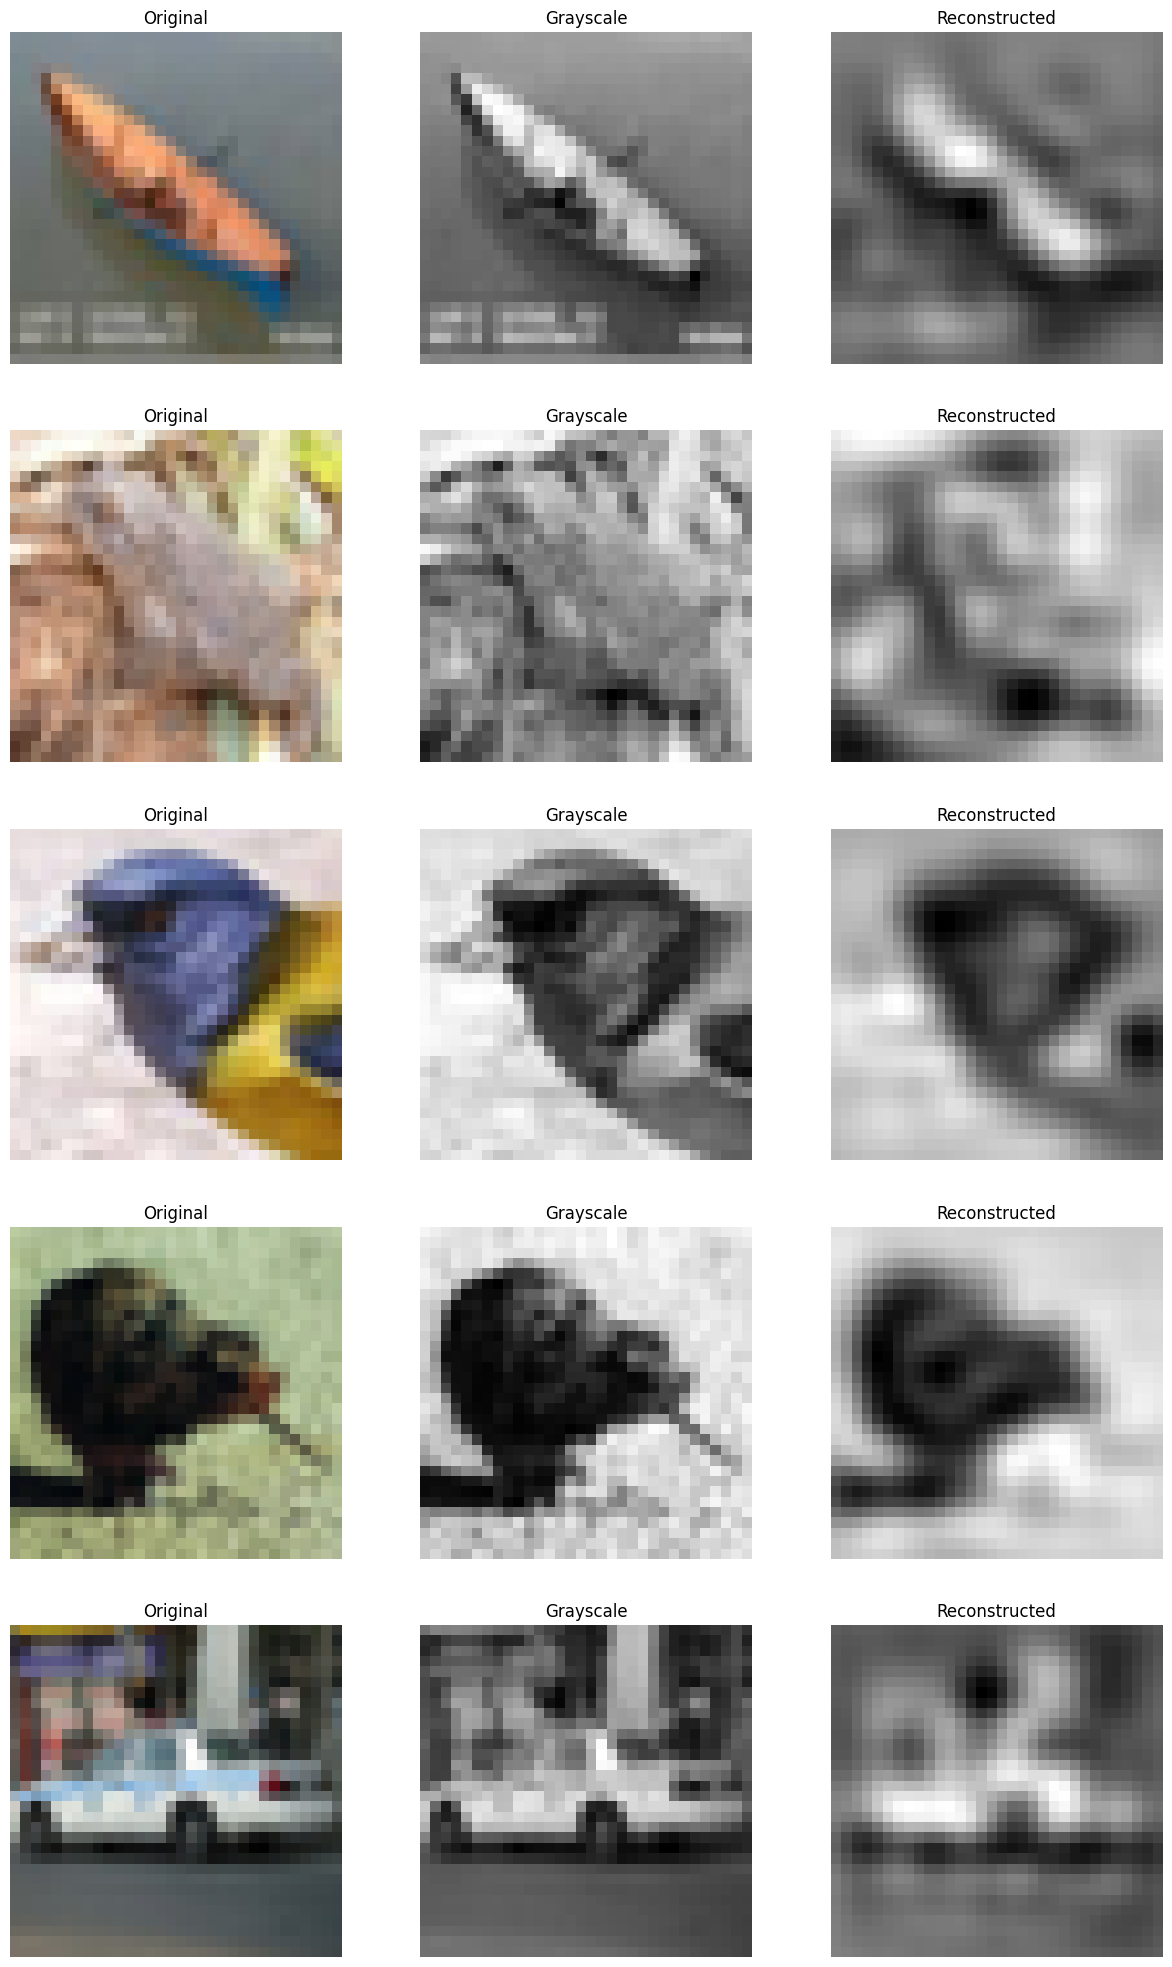

In [15]:
# Display original, grayscale, and reconstructed images for training set
n_images_to_display = 5

# Select random indices for display
display_indices = np.random.choice(len(X_train_gray), n_images_to_display, replace=False)

# Display images
plt.figure(figsize=(15, 5 * n_images_to_display))
for i, idx in enumerate(display_indices, 1):
    # Original image
    plt.subplot(n_images_to_display, 3, 3 * (i - 1) + 1)
    plt.imshow(X_train[idx])
    plt.title('Original')
    plt.axis('off')

    # Grayscale image
    plt.subplot(n_images_to_display, 3, 3 * (i - 1) + 2)
    plt.imshow(tf.squeeze(X_train_gray[idx]), cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Reconstructed image
    plt.subplot(n_images_to_display, 3, 3 * (i - 1) + 3)
    plt.imshow(tf.squeeze(X_train_reconstructed[idx]), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()
